In [2]:
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

#Hyperparameters
a_param = 2.40602424876737
b_param = 3.6653

parameters_dct = { 
    "cag" : [0.00162, 6.8365, 3.294],
    "tag" : [2.40602424876737, 3.6653,0]
}
#flow = a_param*(water_level*b_param)

### Select which file/s to create a rating curve
User should select which reports to create a rating curve from.

**Note:** The rating curve can only be made from completed reports.

In [3]:
import os
from pathlib import Path

def get_all_dir(par_dict):
    par_dict = Path(par_dict)
    all_dirs_and_files = os.listdir(par_dict)
    all_dirs = []
    
    for i in all_dirs_and_files:
        full_path = os.path.join(par_dict,i)
        if os.path.isdir(full_path):
            all_dirs.append(full_path)
    
    return all_dirs

def get_report_xl(dir):
    all_files = os.listdir(dir)
    for file in all_files:
        if file.split(' ')[-1] == 'Report.xlsx':
            full_file = os.path.join(dir,file)
            break
    if len(full_file) == 0:
        raise ValueError
    
    return full_file


In [4]:
def select_a_file(river):
    print('Select Report from list below')
    all_dir = get_all_dir(river)
    dir_dict = {}
    count = 0
    for dir in all_dir:
        dir_dict[count] = dir
        count+=1
    
    for key, val in dir_dict.items():
        print(f"{key}: {val}")
    
    path = int(input("Select"))
    # path_lst_str = str(input("Select: "))
    # path_lst_str = path_lst_str.split(",")
    # path_lst_str = [int(i) for i in path_lst_str]
    
    report_files = get_report_xl(dir_dict[path])
    return report_files

def select_multiple_files_continuous(river):
    print('Select Report from list below(note. Seperate with comma e.g. 1,2,3)')
    all_dir = get_all_dir(river)
    dir_dict = {}
    count = 0
    for dir in all_dir:
        dir_dict[count] = dir
        count+=1
    
    for key, val in dir_dict.items():
        print(f"{key}: {val}")
    
    path_lst_str = str(input("Select: "))
    path_lst_str = path_lst_str.split(",")
    path_lst_str = [dir_dict[int(i)] for i in path_lst_str]
    
    report_files = [get_report_xl(path) for path in path_lst_str]

    return report_files


while True:
    try:
        message = "Select River \n0: Cagayan/San Isidro\n1: Tagoloan"
        which_river = int(input(message))

        # if (which_river != 0) | (which_river != 1):
        #     raise ValueError
            
        river_dict = {0: Path(r"Cleaned_Cagayan"),
                    1: Path(r"Cleaned_Tagoloan")}
        river = river_dict[which_river]

        message = """How many reports will you include \n
        1: 1 Report \n
        2: 2/more Reports \n"""

        no_of_files_condition = int(input(message))

        #Selects which sensor to use especially for tagoloan
        if which_river == 1:
            rg_sensor = str(input("Do you want to use the default sensor RG0? (y for yes, n for no"))
        else:
            rg_sensor = 'y'

        if no_of_files_condition == 1:
            print("Starting individual file analysis")
            report_file = [select_a_file(river)]
        elif no_of_files_condition == 2:
            report_file = select_multiple_files_continuous(river)
            print("Starting multi file analysis")
        else:
            raise ValueError
        
        print("\n\nSuccessfully selected report/s. The selected reports are...")
        pprint(report_file)
        
        break
    except ValueError:
        print('Wrong value, please try again')

Select Report from list below(note. Seperate with comma e.g. 1,2,3)
0: Cleaned_Cagayan\20210106_20210107 Report
1: Cleaned_Cagayan\20210107_20210108 Report
2: Cleaned_Cagayan\20210108_20210109 Report
3: Cleaned_Cagayan\20210109_20210110 Report
4: Cleaned_Cagayan\20210110_20210111 Report
5: Cleaned_Cagayan\20210111_20210112 Report
6: Cleaned_Cagayan\20210112_20211612 Report
7: Cleaned_Cagayan\20210112_20220101 Report
8: Cleaned_Cagayan\20220101_20220102 Report
9: Cleaned_Cagayan\20220101_20220104 Report
10: Cleaned_Cagayan\20220102_20220103 Report
11: Cleaned_Cagayan\20220103_20220104 Report
12: Cleaned_Cagayan\20220104_20220105 Report
13: Cleaned_Cagayan\20220105_20220106 Report
14: Cleaned_Cagayan\20220106_20220107 Report
Starting multi file analysis


Successfully selected report/s. The selected reports are...
['Cleaned_Cagayan\\20210107_20210108 Report\\20210107_20210108 Report.xlsx',
 'Cleaned_Cagayan\\20210108_20210109 Report\\20210108_20210109 Report.xlsx',
 'Cleaned_Cagayan\\202

### Merge

In [5]:
def select_rg(report_file, rg_sensor):
    all_df=[]
    if rg_sensor=='n':
        
        for f in report_file:
            try:
                which_rg = int(input(f'Select RG for {f} (0 for RG0, 1 for RG1)'))
                print(which_rg)
                if which_rg == 0:
                    df = pd.read_excel(f, index_col=0)
                    df = df[['Timestamp','Corrected Water Level', 'RG0_Diff']]
                    df.columns = ['Timestamp','Corrected Water Level', 'Rain Gauge']
                elif which_rg == 1:
                    df = pd.read_excel(f, index_col=0)
                    df = df[['Timestamp','Corrected Water Level', 'RG1_Diff']]
                    print(54)
                    df.columns = ['Timestamp','Corrected Water Level', 'Rain Gauge']
                else:
                    raise ValueError("Wrong RG, try again")
                all_df.append(df)
            except Exception as e:
                print("Select RG", e)
    if rg_sensor == 'y':
        for f in report_file:
            df = pd.read_excel(f, index_col=0)
            df = df[['Timestamp','Corrected Water Level', 'RG0_Diff']]
            all_df.append(df)
    
    main_df = pd.concat(all_df)
    print(main_df.head(5))
    return main_df

if river == river_dict[0]: #if Cagayan
    all_df = [pd.read_excel(path, index_col=0) for path in report_file]
    main_df = pd.concat(all_df)
    main_df = main_df[['Timestamp','Corrected Water Level', 'Rain Gauge']]
    a_param = parameters_dct['cag'][0]
    b_param = parameters_dct['cag'][1]
    init_head = parameters_dct['cag'][2]

if river == river_dict[1]: #if Tagoloan
    print(report_file)
    main_df = select_rg(report_file, rg_sensor)
    main_df.columns = ['Timestamp','Corrected Water Level', 'Rain Gauge']
    a_param = parameters_dct['tag'][0]
    b_param = parameters_dct['tag'][1]
    init_head = parameters_dct['tag'][2]

main_df

,Timestamp,Corrected Water Level,Rain Gauge
Hour,,,
0,2021/07/01 00:00:00,1.677924,0.0
1,2021/07/01 01:00:00,1.677924,0.0
2,2021/07/01 02:00:00,1.629986,0.0
3,2021/07/01 03:00:00,1.629986,0.0
4,2021/07/01 04:00:00,1.558079,0.0
...,...,...,...
20,2021/09/30 20:00:00,2.301118,0.0
21,2021/09/30 21:00:00,2.277149,0.0
22,2021/09/30 22:00:00,2.205242,0.0


### Lets Create the flow given the hyperparameters

In [6]:
main_df.reset_index(drop=True, inplace=True)
main_df = main_df.sort_values(by=['Timestamp'])
water_level = main_df['Corrected Water Level'].to_numpy()
flow = a_param*((init_head+water_level)**b_param)

main_df['Flow'] = flow

Convert timestamp to pandas timestamp

In [7]:
timestamp = main_df['Timestamp']
precipitation = main_df['Rain Gauge']
river_name = str(river).split('_')[-1]

all_figs = []

Get the month and year

In [8]:
month = pd.to_datetime(timestamp[0]).month_name()
year = str(pd.to_datetime(timestamp[0]).year) + ' '

if no_of_files_condition == 2:
    start_month = pd.to_datetime(timestamp[0]).month_name()
    end_month = month = pd.to_datetime(timestamp[timestamp.count()-10]).month_name()
    month = f'{start_month} to {end_month}'

    start_year = pd.to_datetime(timestamp[0]).year
    end_year = pd.to_datetime(timestamp[timestamp.count()-10]).year

    if start_year != end_year:
        month = f'{start_month} {start_year} to {end_month} {end_year} '
        year = ''

Convert other columns to list

### Plot Hydrograph

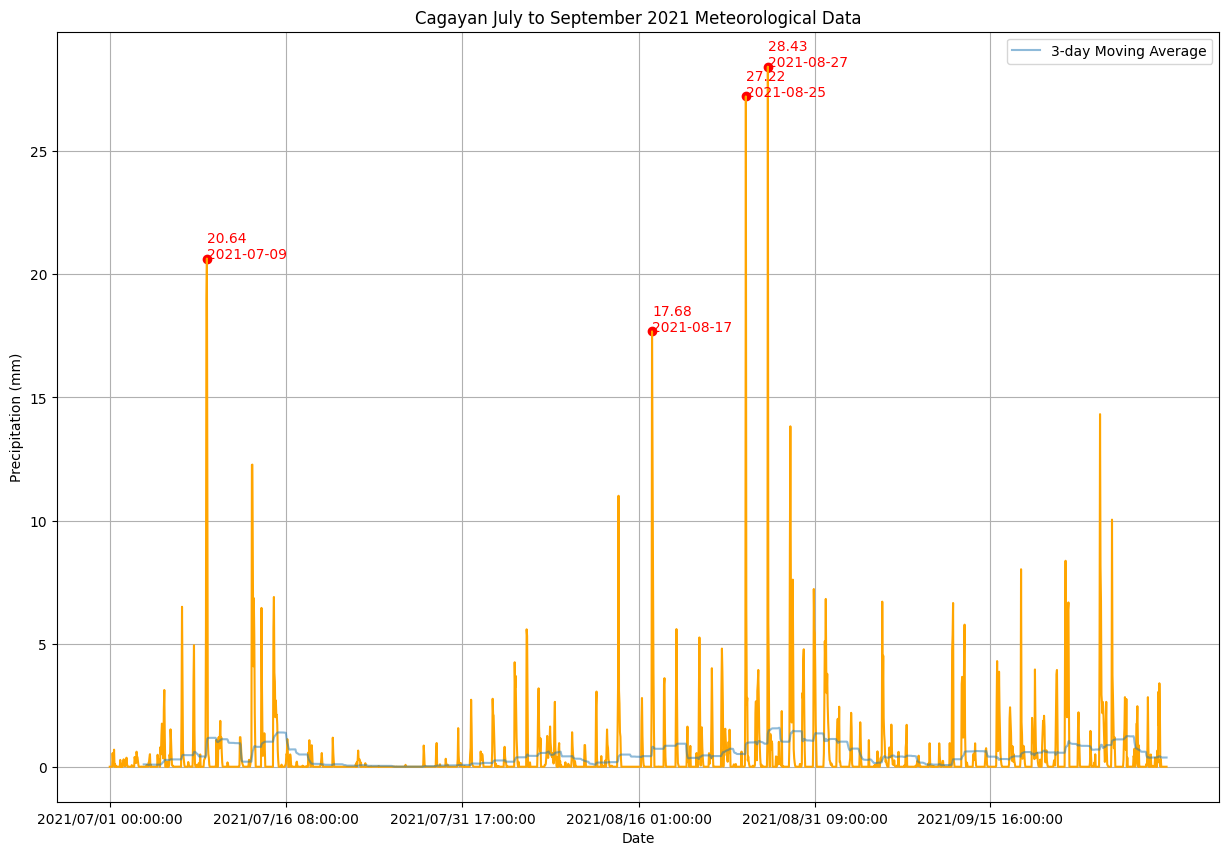

In [9]:
met_fig, ax = plt.subplots(figsize=[15,10])

ax.plot(timestamp,precipitation, color='orange')
#For the Moving Average and Highest Data
def add_high_peaks(timestamp, data, ax, no_of_peaks=3, roll=3):
    temp_df = pd.DataFrame({'Timestamp':timestamp, 'Data':data}).set_index('Timestamp')
    temp_df_roll = temp_df.rolling(window=(24*roll)).mean()
    ax.plot(temp_df_roll.index, temp_df_roll['Data'], label=f"{roll}-day Moving Average", alpha=0.5)
    highest_df = temp_df.sort_values(by='Data', ascending=False)
    highest_indexes = []
    dates = []
    cur = 0
    while True:
        if len(highest_indexes) == 0:
            highest_indexes.append(cur)
            dates.append(pd.to_datetime(highest_df.index[cur]).date())
        cur_date = pd.to_datetime(highest_df.index[cur]).date()
        if cur_date not in dates:
            highest_indexes.append(cur)
            dates.append(cur_date)
        cur += 1       
        if len(highest_indexes) == no_of_peaks:
            break
        
    for i in highest_indexes:
        highest = highest_df['Data'].values[i]
        highest_date = highest_df.index[i]
        ax.text(highest_date, highest, f'{highest:.2f}\n{pd.to_datetime(highest_date).date()}', fontsize=10, color='r')
        ax.scatter(highest_date, highest, color='r')
    ax.legend()
add_high_peaks(timestamp, precipitation, ax, no_of_peaks=4)
ax.set_title(f"{river_name} {month} {year}Meteorological Data")
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation (mm)")

x_ticks_idx = np.linspace(0,len(timestamp), 7).round(0)
x_ticks = [i for idx, i in enumerate(timestamp) if int(idx) in x_ticks_idx]
ax.set_xticks(x_ticks)
ax.grid(True)

all_figs.append(met_fig)

plt.show()

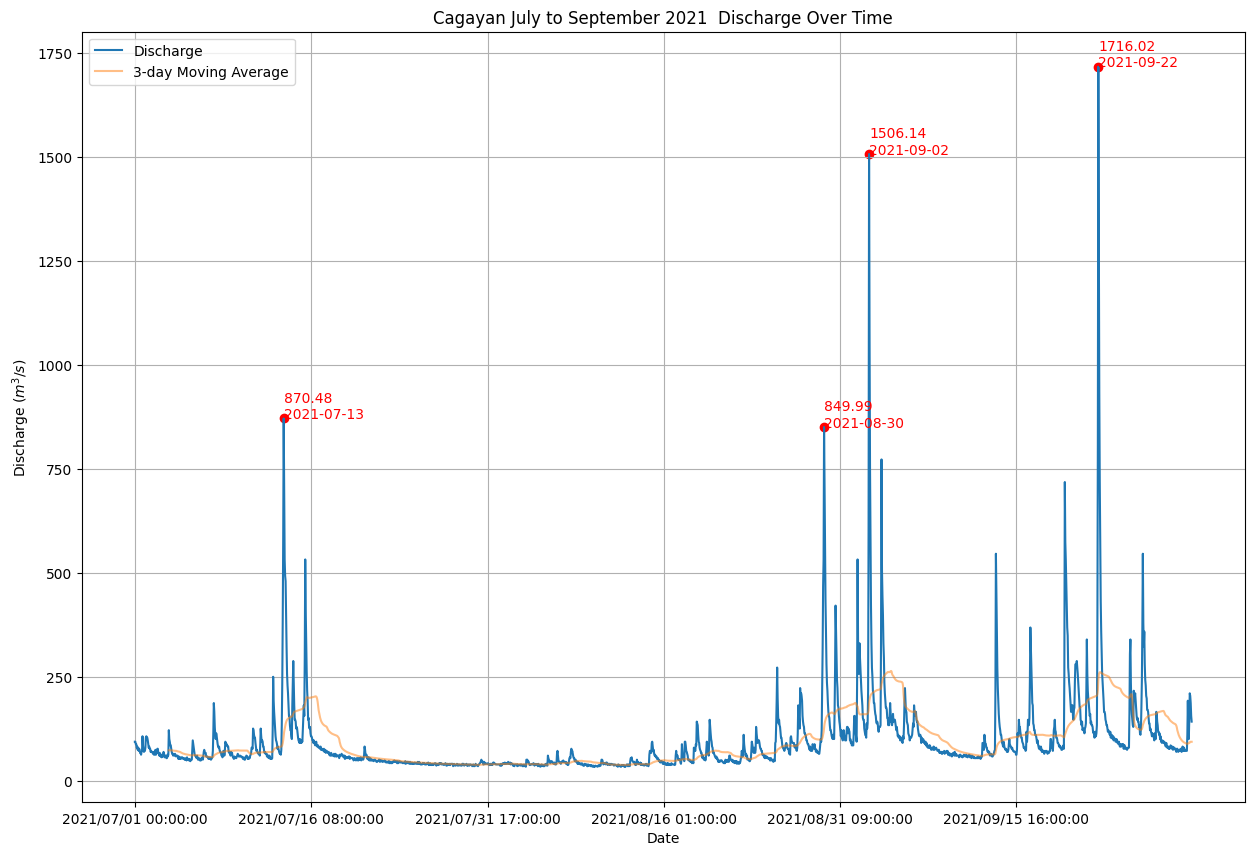

In [10]:
discharge_fig, ax = plt.subplots(figsize=[15,10])

ax.plot(timestamp,flow, label="Discharge")
add_high_peaks(timestamp, flow, ax, no_of_peaks=4)

ax.set_title(f"{river_name} {month} {year} Discharge Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Discharge ($m^3/s$)")

x_ticks_idx = np.linspace(0,len(timestamp), 7).round(0)
x_ticks = [i for idx, i in enumerate(timestamp) if int(idx) in x_ticks_idx]
ax.set_xticks(x_ticks)

ax.grid(True)

all_figs.append(discharge_fig)

plt.show()

Plot Water Level

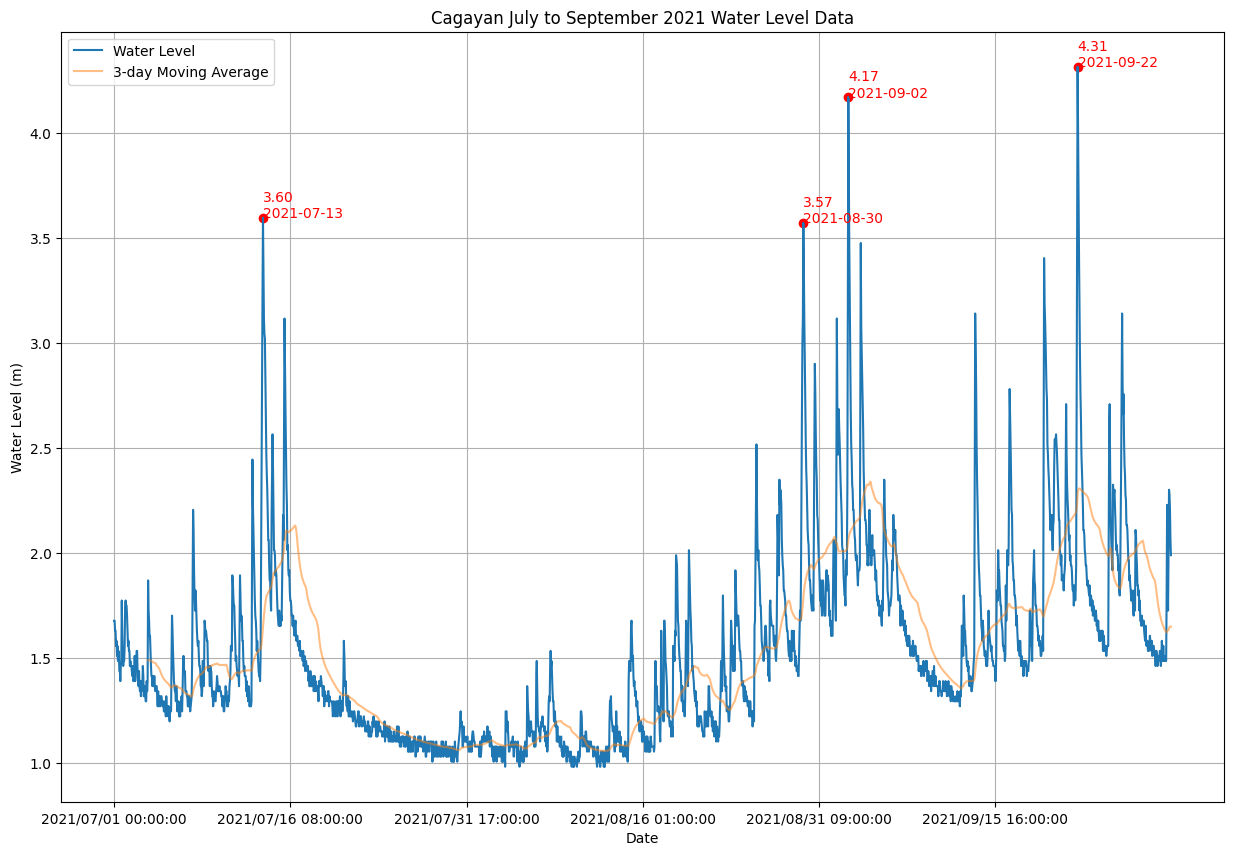

In [11]:
water_fig, ax = plt.subplots(figsize=[15,10])

ax.plot(timestamp,water_level, label="Water Level")
add_high_peaks(timestamp, water_level, ax, no_of_peaks=4)

ax.set_title(f"{river_name} {month} {year}Water Level Data")
ax.set_xlabel("Date")
ax.set_ylabel("Water Level (m)")

x_ticks_idx = np.linspace(0,len(timestamp), 7).round(0)
x_ticks = [i for idx, i in enumerate(timestamp) if int(idx) in x_ticks_idx]
ax.set_xticks(x_ticks)

ax.grid(True)

all_figs.append(water_fig)

plt.show()

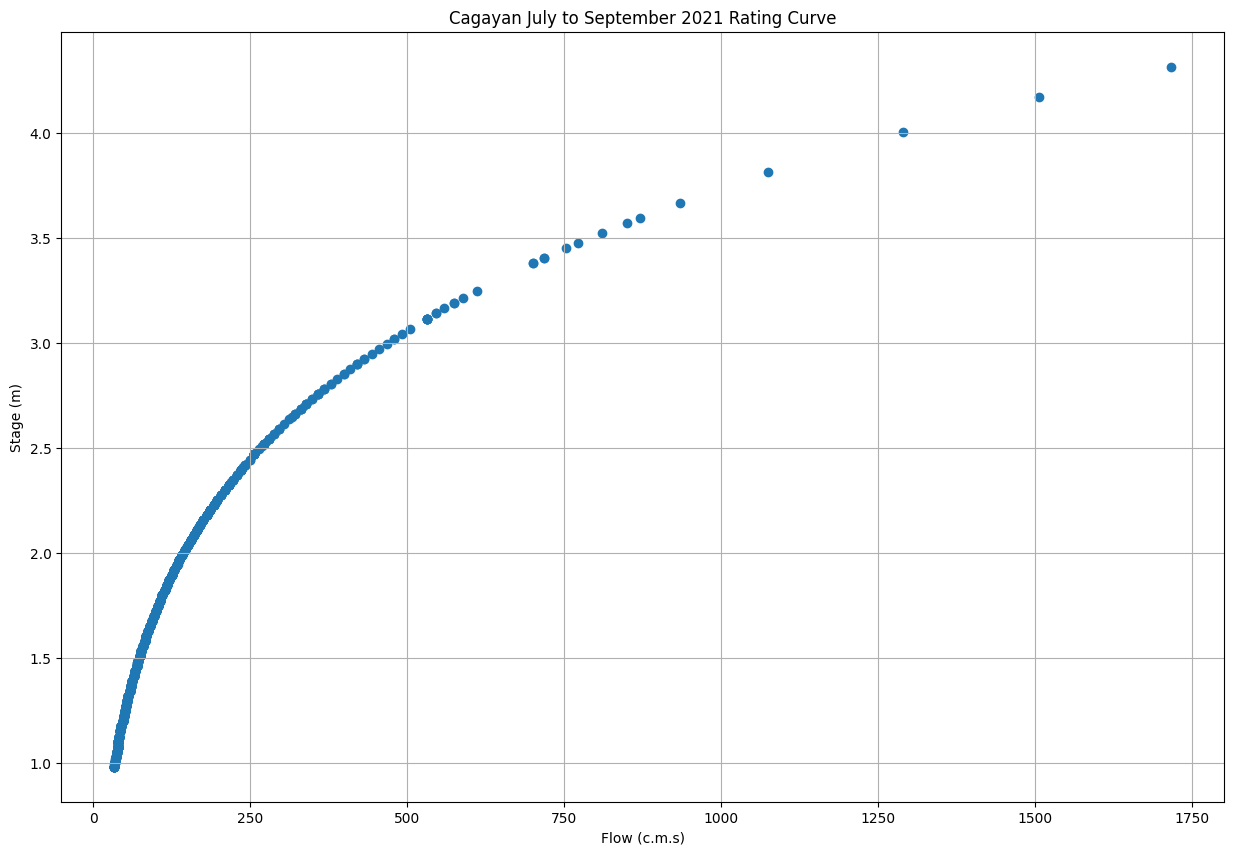

In [12]:
river_name = str(river).split('_')[-1]

rc_fig, ax = plt.subplots(figsize=[15,10])

ax.scatter(flow,water_level)
ax.set_title(f"{river_name} {month} {year}Rating Curve")
ax.set_xlabel("Flow (c.m.s)")
ax.set_ylabel("Stage (m)")
ax.grid(True)

all_figs.append(rc_fig)
plt.show()

In [13]:
main_df.dropna()

,Timestamp,Corrected Water Level,Rain Gauge,Flow
0,2021/07/01 00:00:00,1.677924,0.0,93.606204
1,2021/07/01 01:00:00,1.677924,0.0,93.606204
2,2021/07/01 02:00:00,1.629986,0.0,87.607015
3,2021/07/01 03:00:00,1.629986,0.0,87.607015
4,2021/07/01 04:00:00,1.558079,0.0,79.224745
...,...,...,...,...
2206,2021/09/30 20:00:00,2.301118,0.0,209.851923
2207,2021/09/30 21:00:00,2.277149,0.0,203.782300
2208,2021/09/30 22:00:00,2.205242,0.0,186.464140
2209,2021/09/30 23:00:00,2.061428,0.0,155.566636


### Create Water Level and Precipitation Graph

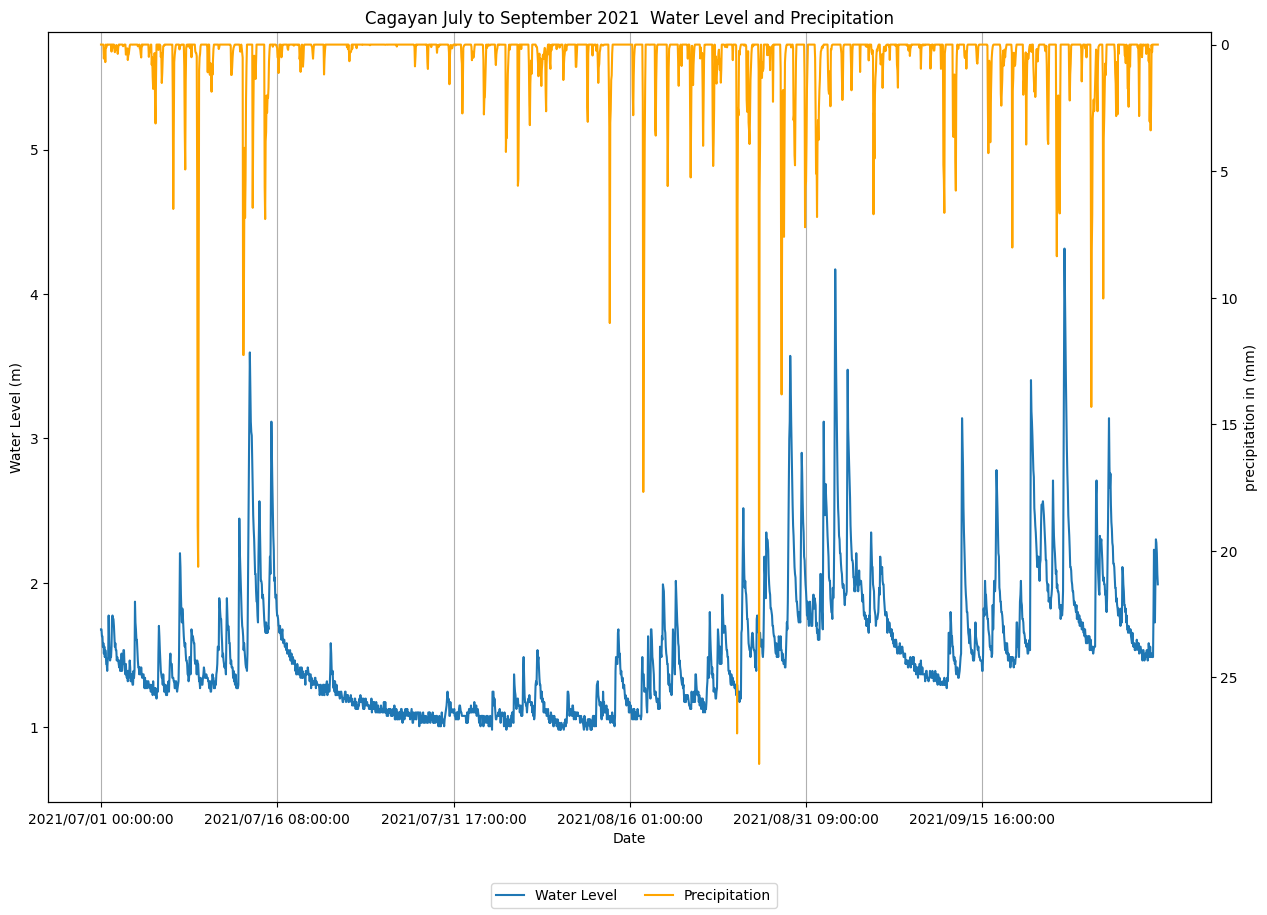

In [14]:
wlp_fig, ax = plt.subplots(figsize=[15,10])

ax.plot(timestamp,water_level, label="Water Level")

ax.set_title(f"{river_name} {month} {year} Water Level and Precipitation")
ax.set_xlabel("Date")
ax.set_ylabel("Water Level (m)")
ax.set_ylim((water_level.min()-0.5,water_level.max()+1.5))

ax2=ax.twinx()
ax2.plot(timestamp,precipitation, label="Precipitation", color='orange')
ax2.set_ylabel("precipitation in (mm)")
ax2.set_ylim((precipitation.min()-0.5,precipitation.max()+1.5))
ax2.invert_yaxis()

x_ticks_idx = np.linspace(0,len(timestamp), 7).round(0)
x_ticks = [i for idx, i in enumerate(timestamp) if int(idx) in x_ticks_idx]
ax.set_xticks(x_ticks)

ax.grid(True, axis='x')

wlp_fig.legend(loc="lower center", ncol=2)

all_figs.append(wlp_fig)

plt.show()

## Comboplot in aggregated and running average form

In [15]:
import seaborn as sns
from IPython.display import display
import math
import datetime


#Preparing the precipitation


def aggregate(timestamp,precipitation, method='sum', column_name='Precipitation', window=7, data_label='Precipitation (mm/day)'):
    aggregated_plot_lst = []
    box_plot_lst = []

    df = pd.DataFrame({'Timestamp':timestamp, column_name:precipitation})
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])

    #Instantiate which day of the month
    df['date'] = df['Timestamp'].dt.strftime('%Y-%m-%d')
    df.sort_values(by='Timestamp', inplace=True)

    df.drop(columns=['Timestamp'], inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values(by='date', inplace=True)

    #Select method
    if method == 'sum':
        df = df.groupby(['date']).sum().reset_index()
        method_str = 'Sum'
    elif method == 'average':
        df = df.groupby(['date']).mean().reset_index()
        method_str = 'Average'
    else:
        raise ValueError("Wrong method, try again")

    #new df for boxplot
    df_boxplot = df.copy()

    #Preparing the boxplot
    print(df_boxplot.columns)
    df_boxplot = df_boxplot.sort_values(by='date').reset_index(drop=True)

    #add week of month
    def add_week_of_month(df, feature):
        df['week_of_month'] = pd.to_numeric(df[feature].dt.day/7)
        df['week_of_month'] = df['week_of_month'].apply(lambda x: math.ceil(x))
        return df
    df_boxplot = add_week_of_month(df_boxplot, 'date')
    df_boxplot = df_boxplot.sort_values(by='date').reset_index(drop=True)
    df_boxplot['week_of_month'] = np.vectorize(lambda date, week:f"Week {week}-{date}")(df_boxplot['date'].dt.strftime('%m-%Y'), df_boxplot['week_of_month'])
    df_boxplot.drop(columns='date', inplace=True)

    #Boxplot
    sns.set_theme(style="whitegrid")
    box_plot, ax = plt.subplots(figsize=[15,10])
    ax = sns.boxplot(x=df_boxplot['week_of_month'], y=column_name ,data=df_boxplot, width=0.5, showfliers=False)
    ticks, text = plt.xticks(rotation=90)

    # set ticks to only 12
    if len(df_boxplot['week_of_month'].unique()) > 12:
        max_no = len(ticks)
        visible_ticks = np.arange(0,max_no, int(max_no/12)).astype(int)
        cleaned_ticks = [(tick, txt) for tick, txt in zip(ticks, text) if tick in visible_ticks]
        tick_numbers = [tick for tick, txt in cleaned_ticks]
        tick_label = [txt for tick, txt in cleaned_ticks]
        ax.set_xticks(tick_numbers)
        ax.set_xticklabels(tick_label)

    #aggregated
    average_boxplot = df_boxplot.groupby('week_of_month').mean()
    std_boxplot = df_boxplot.groupby('week_of_month').std()
    max_boxplot = df_boxplot.groupby('week_of_month').max()
    min_boxplot = df_boxplot.groupby('week_of_month').min()
    aggregated_plot = pd.concat([average_boxplot, std_boxplot, max_boxplot, min_boxplot],join='inner',axis=1)

    #Deal with unorganization
    aggregated_plot.reset_index(inplace=True)
    aggregated_plot['key'] = aggregated_plot['week_of_month'].apply(lambda x: x.split("-")[2] + "-" + x.split("-")[1] + "-" +x.split("-")[0])
    aggregated_plot.sort_values(by='key', inplace=True)
    aggregated_plot = aggregated_plot.drop(columns=['key']).set_index('week_of_month')

    aggregated_plot.columns = ['average','std','max','min']
    ax.plot(aggregated_plot['average'], color='black', label=f"Average {data_label}", linestyle='dashed', alpha=0.5)
    ax.legend()
    ax.set_xlabel("Time")
    ax.set_title(f"Box Plot Trend of Weekly {data_label} Averaged per Day")
    box_plot_lst.append(box_plot)
    box_plot_lst.append(ax)

    

    #Aggregated Plot
    aggregated_fig, ax  = plt.subplots(figsize=[15,10])
    ax.plot(df['date'], df[column_name], color='orange', label=data_label)
    rolling_df = df.set_index("date").rolling(window).mean()
    ax.plot(rolling_df.index, rolling_df[column_name], color='blue', label=f'{window}-day Rolling Average')
    ax.legend()
    ax.set_title(f"Average Daily {data_label}")

    aggregated_plot_lst.append(aggregated_fig)
    aggregated_plot_lst.append(ax)

    daily_df = df
    return daily_df, aggregated_plot, box_plot_lst, aggregated_plot_lst



Index(['date', 'Precipitation'], dtype='object')
Index(['date', 'Water Level'], dtype='object')
Index(['date', 'Flow'], dtype='object')


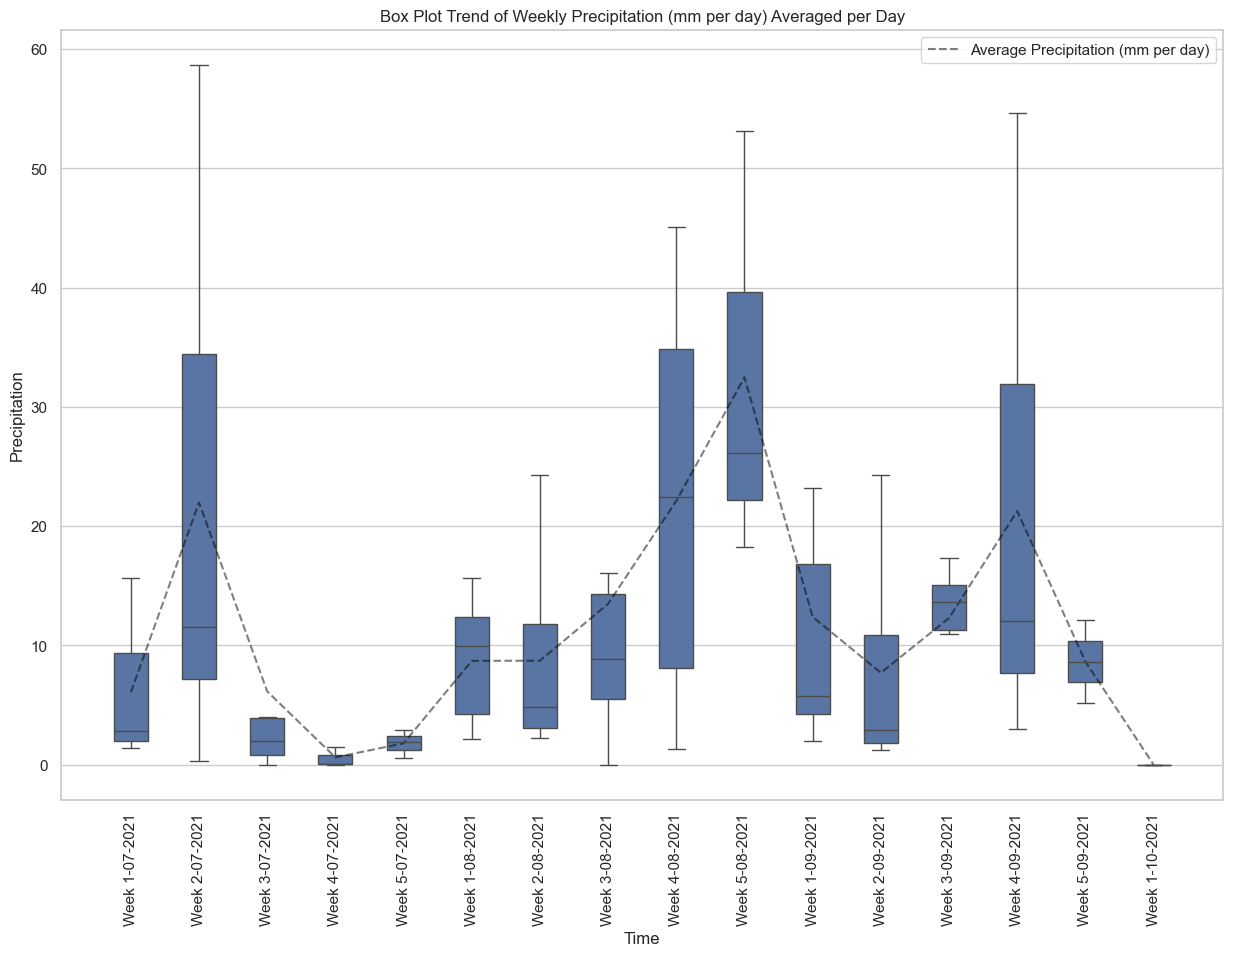

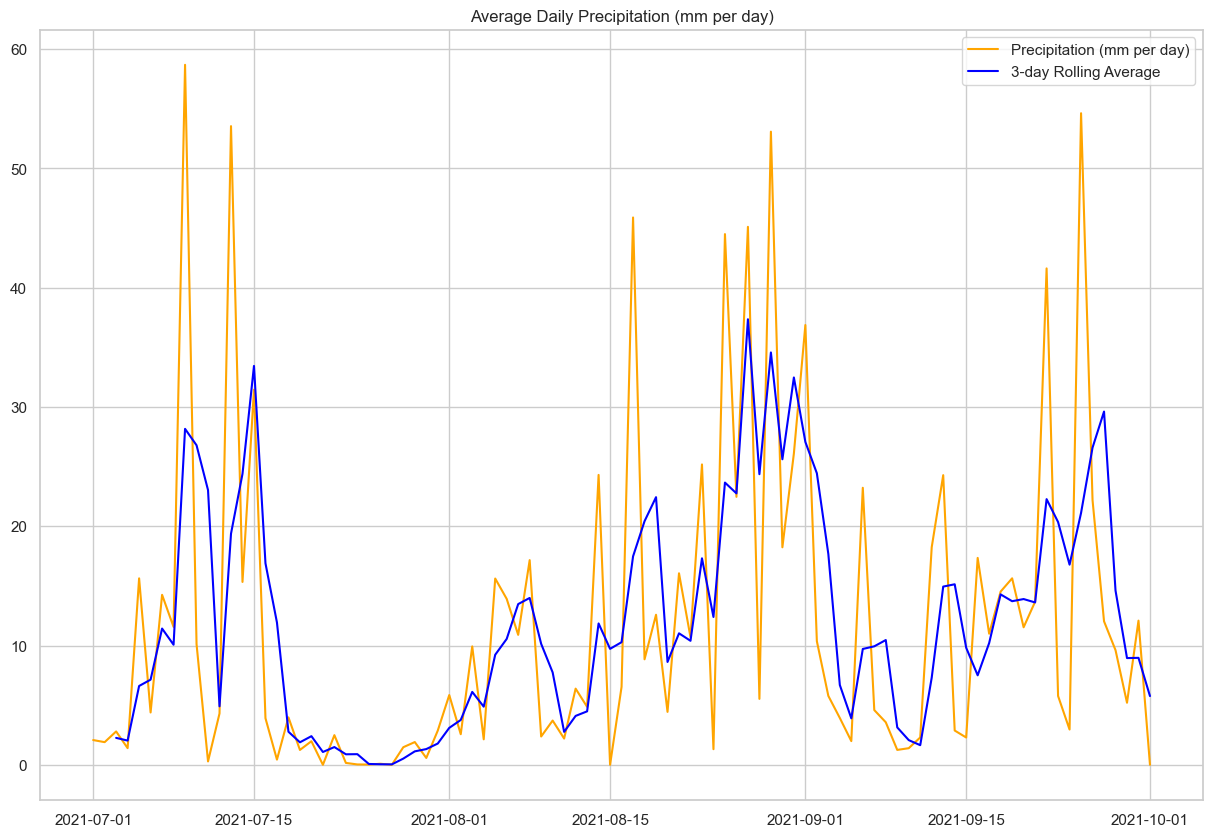

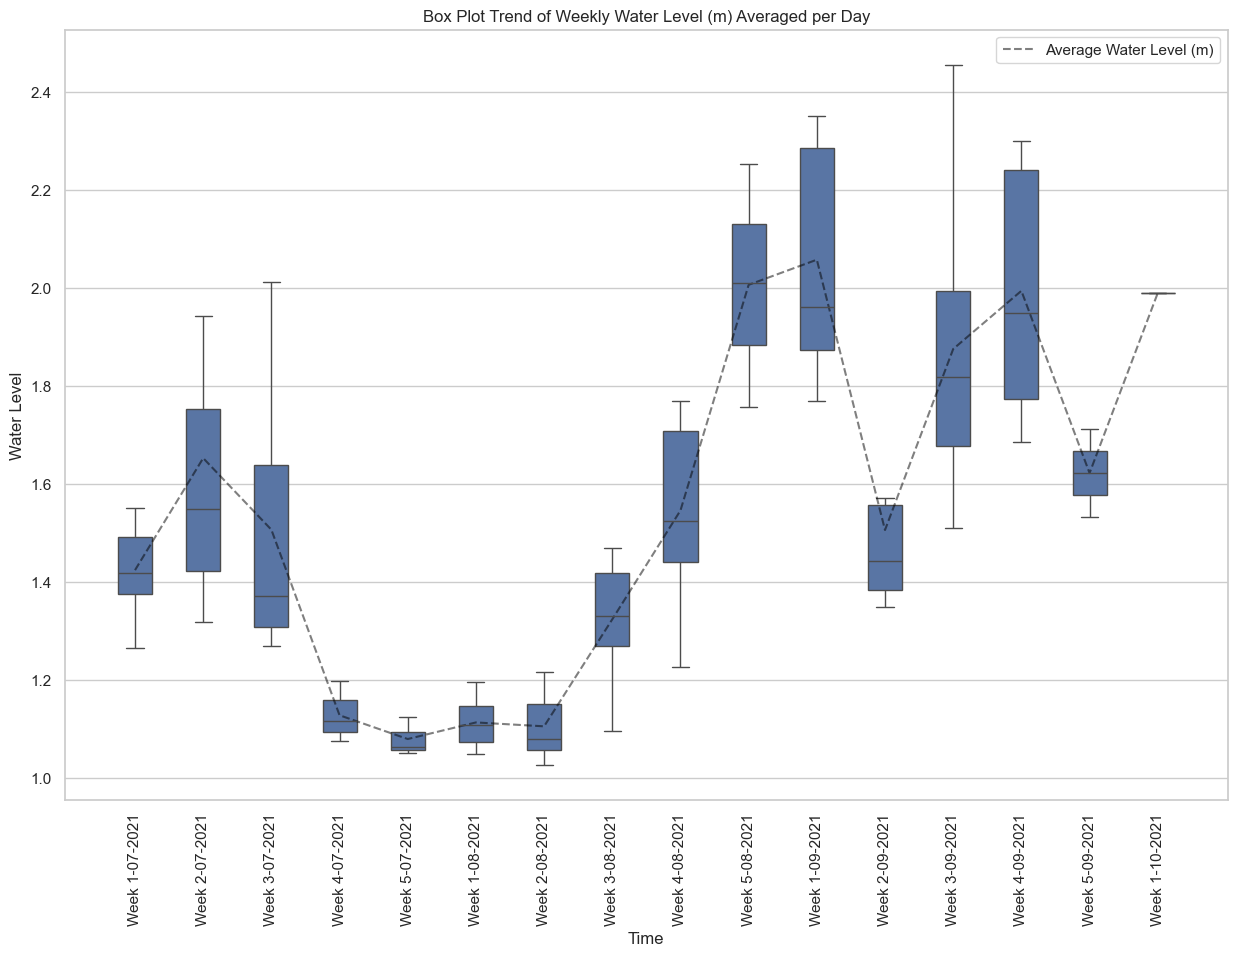

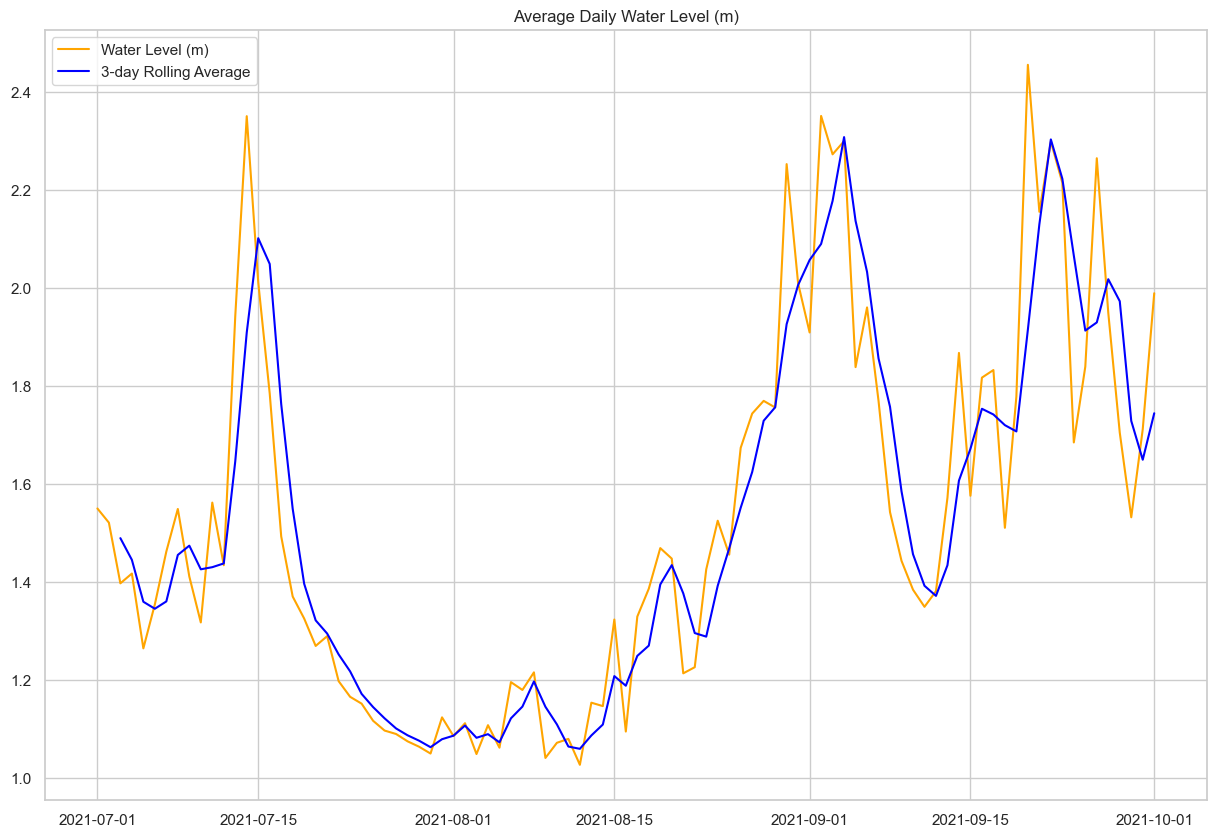

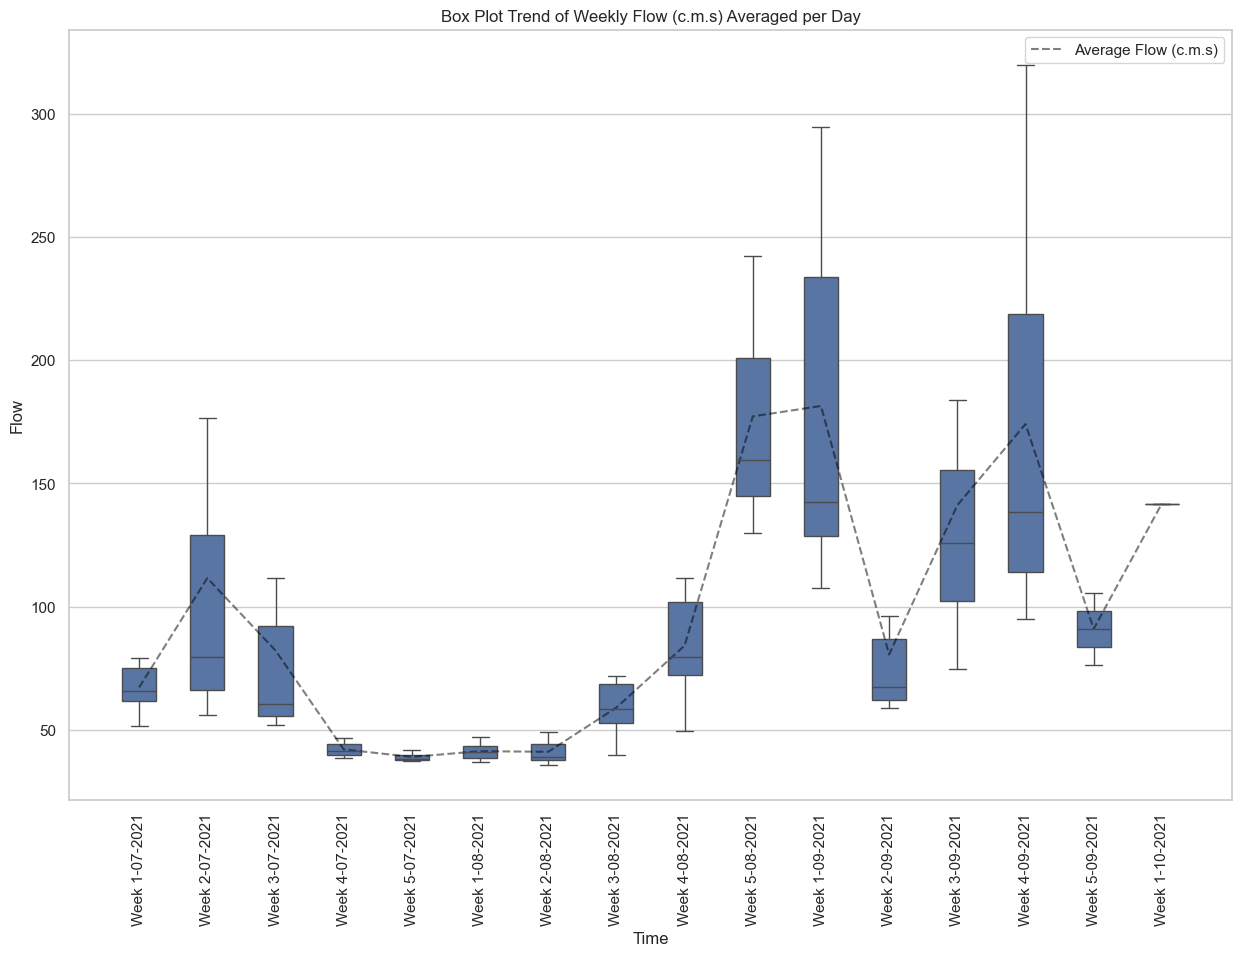

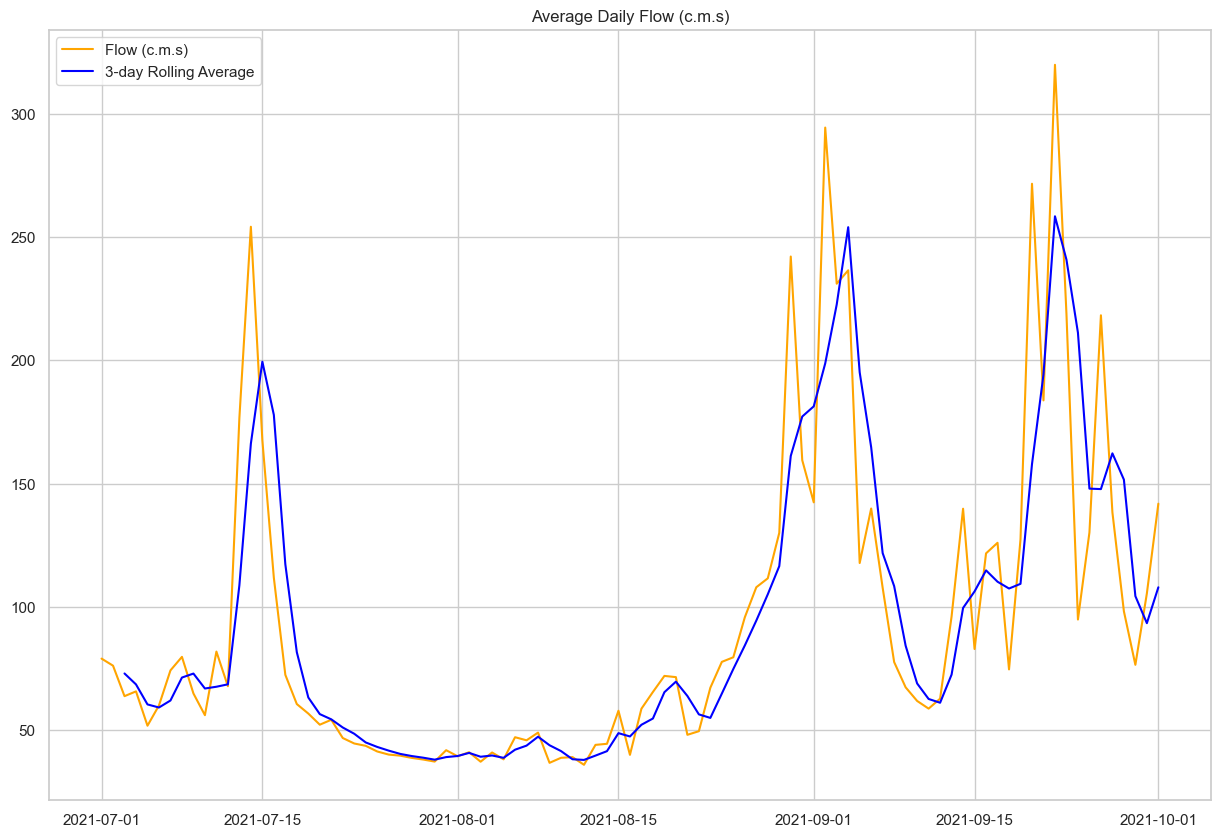

In [16]:
#Create the plot using aggregate function
precipitation_daily_df, precipitation_aggregated_df, precipitation_box_plot, precipitation_aggregated_plot = aggregate(timestamp,precipitation, window=3, data_label='Precipitation (mm per day)')
wl_daily_df, wl_aggregated_df, wl_box_plot, wl_aggregated_plot = aggregate(timestamp,water_level, window=3, data_label='Water Level (m)', method='average', column_name="Water Level")
flow_daily_df, flow_aggregated_df, flow_box_plot, flow_aggregated_plot = aggregate(timestamp,flow, window=3, data_label='Flow (c.m.s)', method='average', column_name="Flow")

#Save the plots to the all_figs list
all_figs.append(precipitation_aggregated_plot[0])
all_figs.append(precipitation_box_plot[0])
all_figs.append(wl_aggregated_plot[0])
all_figs.append(wl_box_plot[0])
all_figs.append(flow_aggregated_plot[0])
all_figs.append(flow_box_plot[0])

#Create a new list for the dataframes for daily and box pl
daily_and_box_df = []
daily_and_box_df.append([precipitation_daily_df, 'Daily Precipitation (Daily Plot)'])
daily_and_box_df.append([precipitation_aggregated_df, 'Weekly Precipitation (Weekly Box Plot)'])
daily_and_box_df.append([wl_daily_df, 'Daily Water Level (Daily Plot)'])
daily_and_box_df.append([wl_aggregated_df, 'Weekly Water Level (Weekly Box Plot)'])
daily_and_box_df.append([flow_daily_df, 'Daily Flow (Daily Plot)'])
daily_and_box_df.append([flow_aggregated_df, 'Weekly Flow (Weekly Box Plot)'])

### Create Water Level and Precipitation Graph

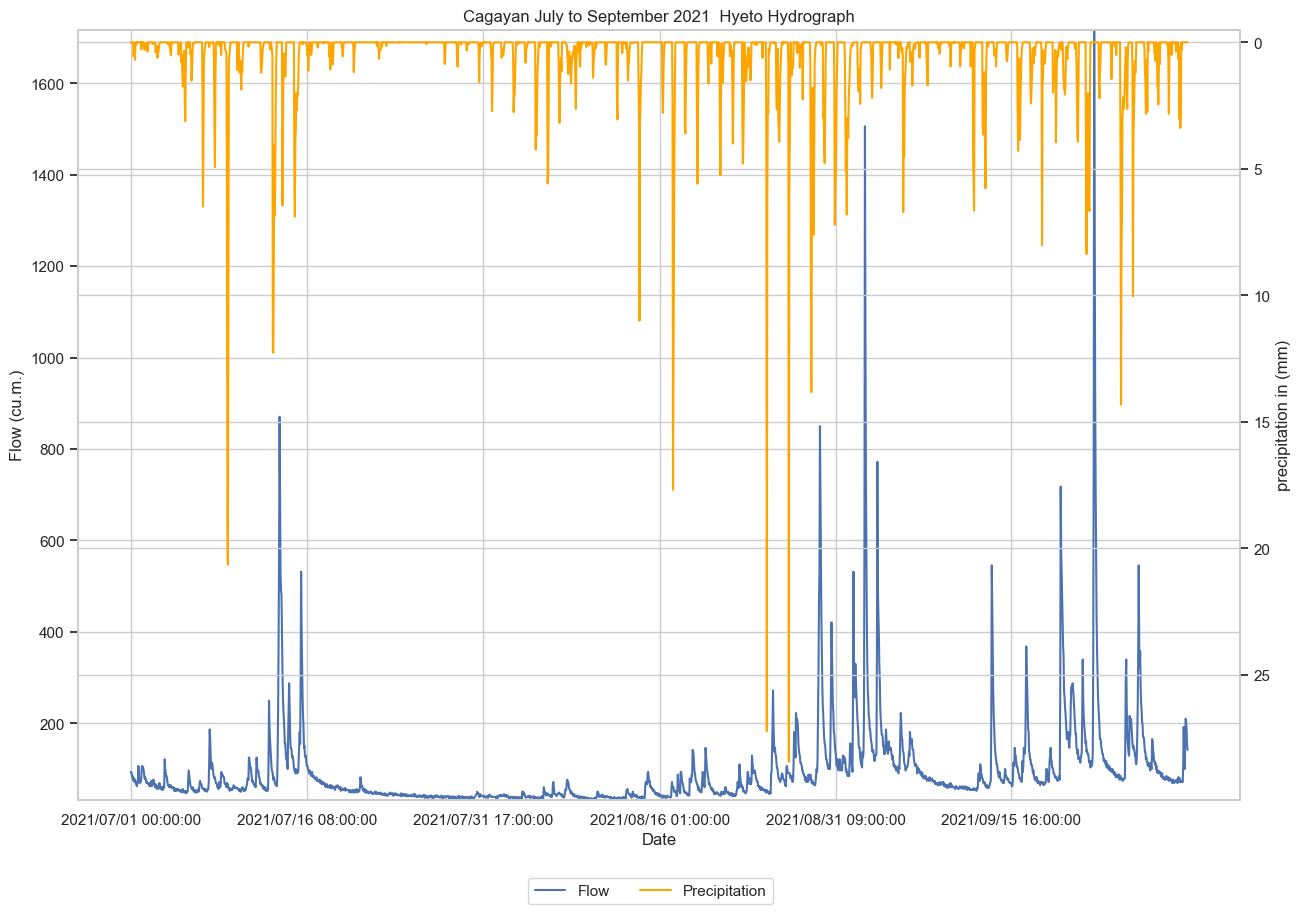

In [17]:
hyeto_hydrograph_fig, ax = plt.subplots(figsize=[15,10])

ax.plot(timestamp,flow, label="Flow")

ax.set_title(f"{river_name} {month} {year} Hyeto Hydrograph")
ax.set_xlabel("Date")
ax.set_ylabel("Flow (cu.m.)")
ax.set_ylim((flow.min()-0.5,flow.max()+1.5))

ax2=ax.twinx()
ax2.plot(timestamp,precipitation, label="Precipitation", color='orange')
ax2.set_ylabel("precipitation in (mm)")
ax2.set_ylim((precipitation.min()-0.5,precipitation.max()+1.5))
ax2.invert_yaxis()

x_ticks_idx = np.linspace(0,len(timestamp), 7).round(0)
x_ticks = [i for idx, i in enumerate(timestamp) if int(idx) in x_ticks_idx]
ax.set_xticks(x_ticks)

ax.grid(True, axis='x')

hyeto_hydrograph_fig.legend(loc="lower center", ncol=2)

all_figs.append(hyeto_hydrograph_fig)

plt.show()

# Optional multirating curve

In [18]:
import matplotlib.colors as mcolors
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import math

def multirating_curve(main_df,month, year):
    colors = list(mcolors.TABLEAU_COLORS.values())

    main_df['Month'] = main_df['Timestamp'].apply(lambda x: pd.to_datetime(x).month_name())

    last_2_months = main_df.iloc[-2:,-1].to_list()

    month_df = [i for _, i in main_df.groupby('Month') if i.Month.iloc[0] not in last_2_months]
    last_2_months_df = main_df.loc[main_df['Month'].isin(last_2_months)]

    month_df.append(last_2_months_df)

    def poly_reg_deg2(flow, water_level):
        flow = np.array(flow)
        water_level = np.array(water_level)
        
        blank_x = np.linspace(min(flow), max(flow)+1, int(len(flow)*10))

        poly = PolynomialFeatures(degree=2, include_bias=False)
        reg = LinearRegression()
        poly_features = poly.fit_transform(flow.reshape(-1,1))
        reg.fit(poly_features, water_level.reshape(-1,1))

        poly_features = poly.fit_transform(blank_x.reshape(-1,1))
        complete_y = reg.predict(poly_features)
        return blank_x, complete_y

    colors = list(mcolors.TABLEAU_COLORS.values())
    water_level_list = []
    flow_list = []
    months = []
    for df in month_df:
        df.reset_index(drop=True, inplace=True)
        water_level_list.append(df['Corrected Water Level'].to_numpy())
        flow_list.append(df['Flow'].to_numpy())
        month_name = df['Month'].iloc[0]
        months.append(month_name)

    mrc_fig, ax = plt.subplots(figsize=[15,10])
    count=0
    for water_level,flow, month_name in zip(water_level_list, flow_list, months):
        color = colors[count]
        ax.scatter(flow,water_level, label=month_name, color=color)
        count += 1

    ax.set_title(f"{river_name} {month} {year}Rating Curve")
    ax.set_xlabel("Flow ($m^3/s$)")
    ax.set_ylabel("Stage (m)")
    ax.grid(True)
    ax.legend()

    poly_mrc ,ax = plt.subplots(figsize=[15,10])
    count=0
    for water_level,flow, month_name in zip(water_level_list, flow_list, months):
        color = colors[count]
        x,y = poly_reg_deg2(flow, water_level)
        ax.plot(x,y, color=color, label=month_name)
        count+=1

    ax.set_title(f"{river_name} {month} {year} Polynomial Rating Curve")
    ax.set_xlabel("Flow ($m^3/s$)")
    ax.set_ylabel("Stage (m)")
    ax.grid(True)
    ax.legend()

    return mrc_fig, poly_mrc

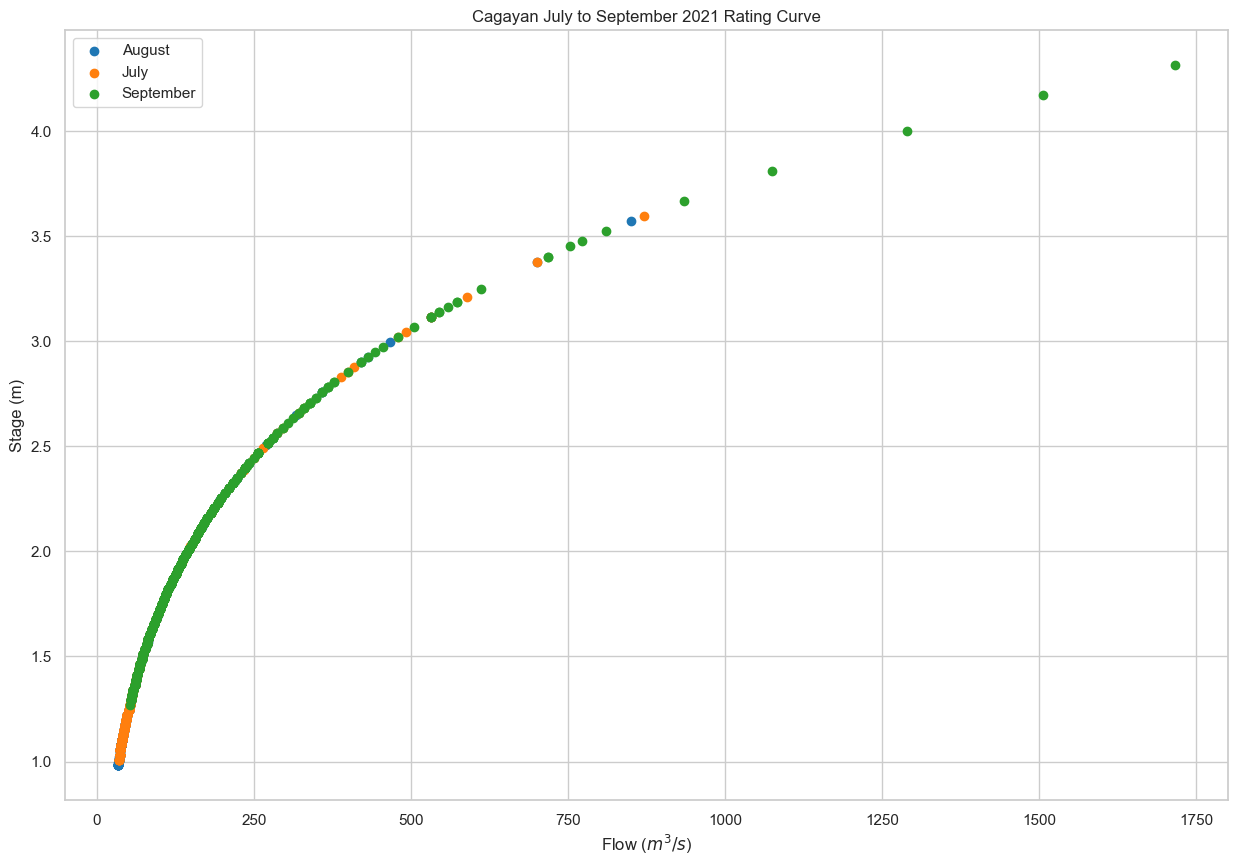

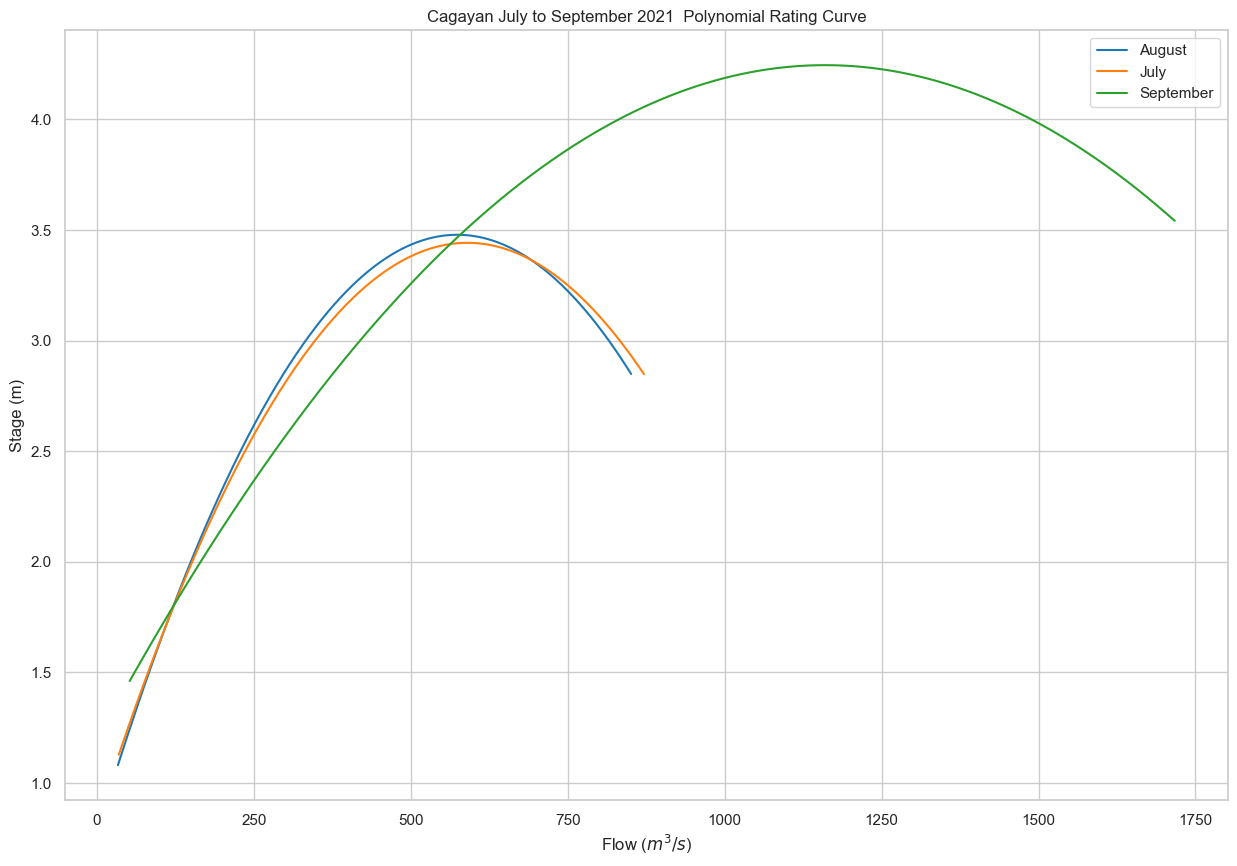

In [19]:
while True:
    try:
        if no_of_files_condition == 2:
            create_mrc = int(input("Do you want to create a multirating curve for each month? (1 for yes, 0 for no.)"))

            if create_mrc == 1:
                mrc_fig, poly_mrc = multirating_curve(main_df, month, year)

                all_figs.append(mrc_fig)
                all_figs.append(poly_mrc)
            
            elif create_mrc == 0:
                print("Will not include multirating curve")
                break
        break
    except ValueError:
        print("Wrong value, please try again")
    

# Saving the Files

In [20]:
from pathlib import Path
par_dir = Path("Hyeto-Hydrograph and Rating Curve Analysis Output")
filename = f"{river_name} {month} {year}"

pic_filenames = [f"{fig.axes[0].get_title()}.png" for fig in all_figs]
directory = os.path.join(par_dir, filename.strip())

try:
    os.mkdir(directory)
    print(f"Creating directory {directory}")
except:
    print("Appending to Existing Directory")

for fig, fname in zip(all_figs,pic_filenames):
    fig.savefig(os.path.join(directory,fname), dpi=600, bbox_inches = 'tight')

Creating directory Hyeto-Hydrograph and Rating Curve Analysis Output\Cagayan July to September 2021


In [21]:
def sort_per_col(df, lst):
    """Create and sort a new df per column and returns all the dfs and its corresponding name"""
    all_df = []
    df_names = []

    all_df.append(df.describe())
    df_names.append("Description")
    all_df.append(df)
    df_names.append("Raw")
    for col in lst:
        df1 = df.sort_values(col, ascending=False)
        df1_name = f"Sorted {col}"
        all_df.append(df1)
        df_names.append(df1_name)
    return df_names, all_df

df_names, all_df = sort_per_col(main_df, ['Corrected Water Level',"Rain Gauge","Flow"])
xl_directory = os.path.join(directory, filename.strip()+' Summative Excel.xlsx')
xl_writer = writer = pd.ExcelWriter(
    xl_directory,
    engine="xlsxwriter",
    datetime_format="mmm d yyyy hh:mm:ss",
    date_format="mmmm dd yyyy")
with xl_writer as writer:
    for fname, df in zip(df_names, all_df):
        try:
            df['Timestamp'] = pd.to_datetime(df['Timestamp'])
            df.to_excel(writer, sheet_name=fname, float_format='%.6f')
        except KeyError:
            df.to_excel(writer, sheet_name=fname, float_format='%.6f')
#For the daily aggregated and weekly plot
xl_writer = writer = pd.ExcelWriter(
    os.path.join(directory, "Daily and Weekly Summary.xlsx"),
    engine="xlsxwriter",
    datetime_format="mmm d yyyy hh:mm:ss",
    date_format="mmmm dd yyyy")
with xl_writer as writer:
    for df, sheet_name in daily_and_box_df:
        if len(sheet_name) > 31:
            sheet_name = sheet_name[:31]
        df.to_excel(writer, sheet_name=sheet_name, float_format='%.6f')
        
        

print(f"All figures and the main report are saved to the {directory} folder")

All figures and the main report are saved to the Hyeto-Hydrograph and Rating Curve Analysis Output\Cagayan July to September 2021 folder


In [22]:
main_df

,Timestamp,Corrected Water Level,Rain Gauge,Flow,Month
0,2021-07-01 00:00:00,1.677924,0.0,93.606204,July
1,2021-07-01 01:00:00,1.677924,0.0,93.606204,July
2,2021-07-01 02:00:00,1.629986,0.0,87.607015,July
3,2021-07-01 03:00:00,1.629986,0.0,87.607015,July
4,2021-07-01 04:00:00,1.558079,0.0,79.224745,July
...,...,...,...,...,...
2206,2021-09-30 20:00:00,2.301118,0.0,209.851923,September
2207,2021-09-30 21:00:00,2.277149,0.0,203.782300,September
2208,2021-09-30 22:00:00,2.205242,0.0,186.464140,September
2209,2021-09-30 23:00:00,2.061428,0.0,155.566636,September
